<h1>Hands On: Support Vector Machines.</h1>

En este notebook se estudia el uso de Support Vector Machine (SVM) para modelización. Es un modelo capaz de hacer clasificación, regresión e incluso detección de atípicos y tanto lineal como no lineal. Es un algoritmo particularmente bueno para clasificación de datasets complejos pero de tamaño pequeño o mediano. Las partes que se estudiarán son las siguientes:

  - Clasificación por SVM Lineal: Large Margin Classification y Soft Margin Classification
  - Clasificación por SVM No Lineal: Kernel polinómico, Funcion Similarity, Kernel Gaussiano RBF y complejidad computacional.
  - Regresión por SVM.
  - Under the hood: Decision function y predicciones, objetivo del entrenamiento, el problema dual, kernelized SVM y SVM online.
  
El objetivo es explicar los conceptos core de SVM, como usarlos y como funcionan.

<h3>Imports</h3>

In [1]:
# Imports generales:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures


# Algoritmos:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

<h2>Clasificación por SVM Lineal</h2>

La idea fundamental de los SVM es crear aquella decision boundary que, no solo separe los grupos en el hiperespacio de las variables usadas, si no que maximice la distancia entre estos grupos (mediante la métrica empleada). El concepto por el que se define el boundary es similar a otros ML, pero el factor diferencial del SVM es el "margin": en el SVM se define un "espacio" cercano al boundary (y con una "distancia" constante al mismo) que es el margen del SVM.

En función de la posibilidad de separar totalmente o no las clases (es decir, permitir que instances del dataset de entrenamiento caigan o no en el margin o en el espacio de la otra clase), se habla de "Large Margin Classification" o "Soft Margin Classification".

<h3>Large Margin Classification (Hard Margin)</h3>

La idea del Large Margin es encontrar aquel boundary que se aleje lo mas posible de ambos grupos a la vez. Es por eso que ese boundary tendra n-1 dimensiones (donde n sean las variables usadas por el modelo).

El punto que diferencia es que añadir mas instancias al dataset no cambia el boundary en tanto en cuanto que este sólo viene determinado por aquellas instancias mas cercanas al resto de grupos. Estas instancias son las llamadas "Support Vectors".

Nota: la representación de los SVMs es muy sensible a las escalas de las variables usadas, por lo que hay que normaliar las variables antes de usarlas si se quiere ver gráficamente de una forma correcta.

En el ejemplo del dataset Iris, se podría ver gráficamente de la siguiente forma:

In [2]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

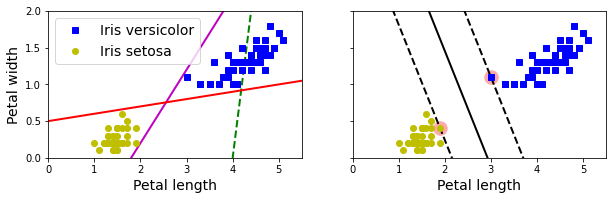

In [3]:
# "Modelos" malos
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

La imagen de la derecha es un Large Margin Classificator, y los elementos resaltados son los support vectors. En la izquierda son los "Modelos Malos" para comparar.

<h3>Soft Margin Classification</h3>

Si en lugar de imponer que todas las instancias de cada clase estén a un "lado" del boundary (Large Margin Classification), podemos hablar de Hard Margin. Aquí hay problemas: el primero, sólo funciona si los datos son linealmente separables.; y segundo, es bastante sensible a atípicos. Por ejemplo:

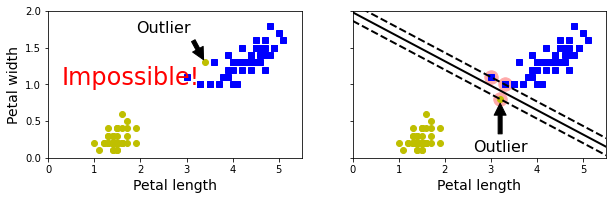

In [4]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

Para solucionar esto, es preferible usar modelos mas flexibles. El objetivo es encontrar un balance entre mantener el margen lo mayor posible y limitar los "margin violation" (los que se van al otro grupo). Esto es lo llamado Soft Margin Classification.

En Sklearn SVM, se puede controlar esto con el hiperparámetro C. Un valor pequeño de C permite mas "margin violation", es decir, es mas laxo a la hora de establecer el margin. Al final, este margin modifica los parámetros del decision boundary. Por poner en ejemplo:

(4.0, 5.9, 0.8, 2.8)

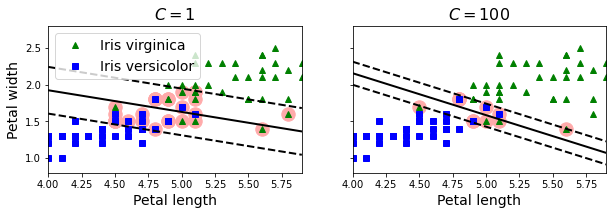

In [5]:
# Se prepara el dataset y se entrenan los modelos SVC escalando previamente los datos
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

# Para definir la loss function: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
# La standard del lineal es "hinge"
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# Se desescalan los parámetros
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Se encuentran los Support Vectors (esto no lo hace SVM solo). La idea es pintarlos luego
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])


Parece que el modelo con C más bajo generaliza mejor en este caso.

Por supuesto, como en cualquier otro modelo, se puede usar para hacer predicciones sobre instances nuevas:

In [6]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])
svm_clf.fit(X,y)
svm_clf.predict([[5.5,1.7]])

array([1.])

De forma alternativa, se puede usar la clase SVC estableciendo los parámetros SVC(kernel='linear', C=1). Esto es mucho más lento, sobre todo para training sets largos. Otra opción es usar SGDClassifier(loss='hinge', alpha=1/(m*C)). Esto aplica Stochastic Gradient Descent para entrenar un clasificador SVM lineal. Converge más lento que un LinearSVC, pero se puede usar para manejar Datasets que no quepan en memoria (Out-Of-Core training), o para clasificaciones online.

Nota: El LinearSVC regulariza el término bias, así que el training set se debe centrar antes. StandardScaler lo hace automáticamente. Además, la loss function por defecto de LinearSVC no es "hinge", si no "squared_hinge", así que hay que pasarlo como hiperparámetro. Por último, si hay menos features que instancias de entrenamiento, es conveniente (para un mejor rendimiento) definir el hiperparámetro dual='False'. Luego estudiamos más a fondo este concepto.

Más info aquí: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

<h2>Clasificación por SVM No Lineal</h2>

Los SVM lineales suelen funcionar bastante bien. Sin embargo, a veces hay datos que no son linealmente separables. Para estos casos, una aproximación válida es añadir features no lineales (p.e. polinómicas), y a veces lo convierte en linealmente separable.

Esto se puede hacer en Sklearn con "PolynomialFeatures", seguido por StandardScaler y LinearSVC. Un ejemplo:


/home/kiko/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


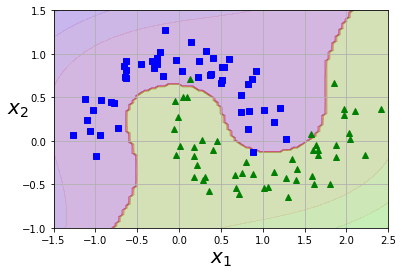

In [7]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

<h3>Kernel Polinómico</h3>

La estrategia de añadir features polinómicas funciona muy bien y vale para todos los algoritmos ML, pero conlleva el riesgo de poner demasiados pocos grados (y ser incapaz de captar la complejidad del dato) o demasiados grados (y ser muy lento entrenando, e incluso overfittear).

En SCM, se puede usar el Kernel Trick, que hace posible obtener el mismo resultado que añadiendo muchos grados polinómicos, pero sin añadirlos. Esto hace que no haya una combinatoria alta de features (porque realmente no añades ninguna).

La clave, en el método SVC de Sklearn, es el parámetro "coef0" (tambien llamado r): este controla cuánto del modelo se ve influenciado por polinomios de grado alto vs de grado bajo:

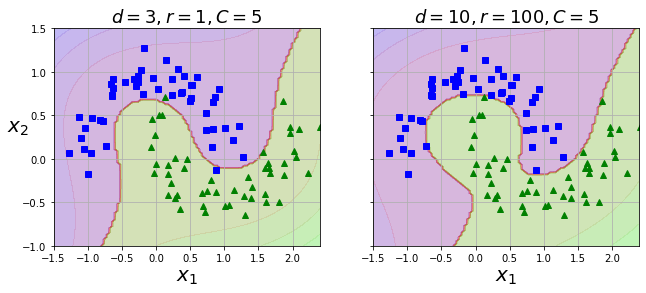

In [8]:
# Primer modelo d=3, coef0=1 y C=5:


poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)


# Segundo modelo: d=10, coef0=100 y C=5

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)


# Se plottea
ig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

Normalmente, para encontrar el hiperparámetro correcto, se usa un grid search. Primero se hace un grid search muy general, y luego otro para hacer el ajuste fino. Para esto ayuda saber qué hace cada hiperparámetro.

<h3>Función Similarity</h3>

Otra técnica para problemas no lineales es añadir features usando una Similarity Function que pondere las instancias con respecto a un "landmark" (puntos genéricos).

Por ejemplo, cogiendo el dataset anterior y dos landmarks en x_1=-2 y x_1=1, se puede definir la funcion Gaussian Radial Basis (RBF) con y=0.3:

    Lambda(x,l) = exp(-gamma* || x-l || ²)

Esta función es una "bell shape" que va de 0 a 1. Ya podemos añadir nuevas features. P.e. para x_1=-1, se encuentra a 1 del primer landmark y 2 del segundo, así: x_2 = exp(-0.3*1²)~0.74 y x_3=exp(-0.3*2²)~0.3.

Gráficamente sería así:

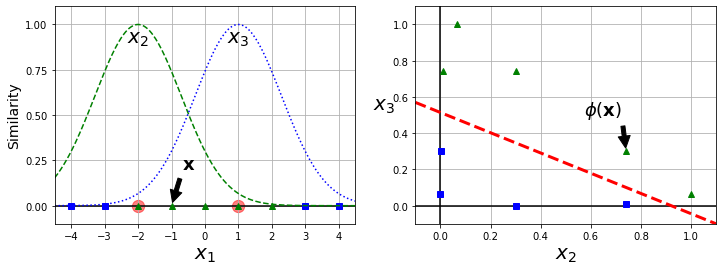

In [9]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

La pregunta es, ¿cómo elegir los Landmarks?. La forma fácil es hacer que cada instancia sea un landmark. Eso crea tantas dimensiones como instancias, aumentando la posibilidad de que sea linealmente separable. La pega es que acabas con un dataset con m instancias y m features (asumiendo que pasas de las originales). Si tu training set es grande, eso hace que tus features también sean muchas.

<h3>Kernel Gaussiano RBF</h3>

Como pasa con el método de PolynomialFeatures, el de la función Similarity también se puede usar en cualquier ML, pero puede ser computacionalmente costoso tratar todas las features. Sin embargo, se puede hacer el truco de SVM de computar como si las hubieses añadido, pero sin añadirlas (de nuevo con el método SVC). Sería tal que así:

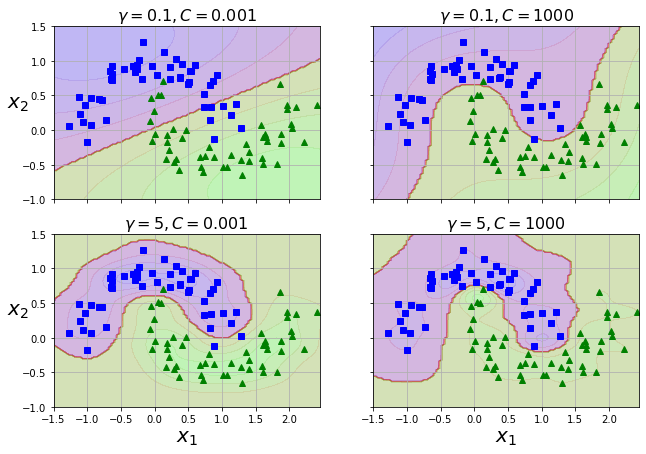

In [10]:
# Al poner kernel="rbf" le decimos que use el kernel gaussiano RBF. Vamos a entrenar las combinaciones de gamma1, 
# gamma2, c1 y c2 para ver como funciona cada hiperparámetro
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

Como se puede ver, aumentar gamma hace que el borde sea mas irregular, bordeando algunas instances particulares. Por otro lado, un gamma pequeño hace que la bell shape sea mas amplia, haciendo que cada instancia tenga un mayor rango de influencia. Así que gamma actua como un hiperparámetro de regularización, y si tu modelo hace overfitting debes reducirlo, y si hace underfitting debes aumentarlo (similar a C).


Hay otros kernels, pero son mucho más raros y se usan solo en estructuras de datos concretas. Por ejemplo, el string kernel se usa para clasificar documentos de texto o secuencias de ADN (p.e. el string subsequence kernel o kernels basados en la distancia de Levenshtein ("Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.")

Con tantos Kernels, ¿cómo saber cual usar?. Por norma general, primero se prueba el kernel lineal (LinearSVC es mucho mas rapido que SVC(kernel='linear') ), sobre todo si el dataset es muy grandeo o tiene muchas features. Si el training set no es muy grande, conviene probar tambien el Gaussian RBF (suele ir bien).
Luego, si tienes tiempo y poder computacional, puedes probar otros kernels usando CV y grid search, sobre todo si hay alguno concreto (como el caso de los basados en Levenshtein).

<h3>Complejidad Computacional</h3>

Existen 2 métodos típicos para hacer SVC en Sklearn. Tienen distintas características y distinta complejidad, son los siguientes:

    - LinearSVC (0(mxn)): Escala linealmente con el número de instancias y de features, pero no soporta el kernel trick: El algoritmo tarda bastante si quieres una precisión alta, pero tiene un hiperparámetro de tolerancia eta (en Sklearn es "tol") para controlar esto. La mayoría de las veces el default está bien.
    
    - SVC (entre 0(m²xn) y 0(m³xn)): La complejidad computacional es mayor, pero soporta el kernel trick. Sin embargo, a medida que las instances (m) aumentan (p.e. cientos de miles), se vuelve considerablemente más lento. Es perfecto para dataset complejos pero pequeños o medianos. Además, escala relativamente bien con el número de features, sobre todo si son sparse, es decir, con ceros, que escala con el promedio de no-ceros por instance.
    
Ambos necesitan escalado de los datos, y, por ponern en contexto, la complejidad de un SGDClassifier es de 0(mxn), aunque este soporta Out-of-core support.

<h2>Regresión por SVM<h2>

El truco para utilizar SVM para hacer regresión (lineal y no lineal) es intentar incluir todas las instances posibles dentro del margin (mientras se limitan los margion violation, es decir, las que caen fuera).

El ancho del margen se controla con el hiperparámetro epsilon.

Nota: La clase SVM se puede usar para outlier detection. Mirarlo en la docu de Sklearn.

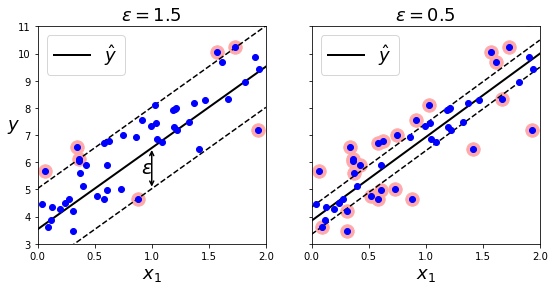

In [11]:
# Se generan los datos: 
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

# Se entrena una regresión lineal con epsilon=1.5 y otra con 0.5
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

# Hacemos el plot para verlo

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()




Ese era un ejemplo de regresión lineal. Para manejar regresiones no lineales se puede usar el modelo SVM kernelizado. Por ejemplo:

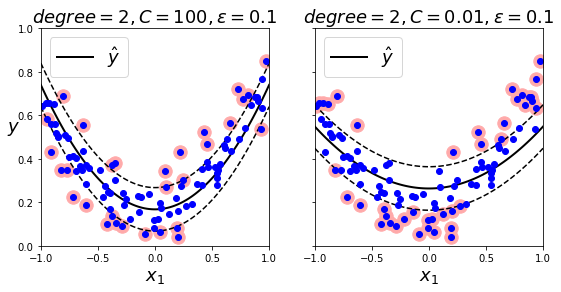

In [12]:
# Datos no lineales:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

# Se crean las regresiones:
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

# Se pinta:


fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()


<h2>Under the hood</h2>

Vamos a ver un poco como el SVM hace las predicciones y como funciona el entrenamiento de los algoritmos, empezando con el SVM de clasificación.

Notación: Hasta ahora Theta es el vector de los parámetros del modelo (incluyendo el bias en Theta_0 y los pesos de cada variable en Theta_1...Theta_n). EN ESTA SECCIÓN CAMBIA: el término bias va a ser b, y el vector de pesos (sin bias) va a ser w.

<h3>Decision Funcion y Predicciones</h3>

Un modelo clasificador lineal de SVM predice la clase simplemente computando la función de decisión w^T + b, o lo que es lo mismo, multiplicando los pesos por las variables y sumando el bias. Si el resultado es positivo se predice la clase (1), y si es negativo la 0.

Esto hace que la función de decisión tenga n-1 dimensiones. Así si el vector de variables tiene 2 componentes, la función de decisión será una línea; si tiene 3 componentes será un plano; etc.

<h3>Objetivo del entrenamiento</h3>

A la hora de entrenar el SVM, uno de los factores a considerar es el tamaño de margen que se quiere poner.

Analizando el modelo, el factor que refleja el comportamiento del margen es la pendiente (slope) de la función de decisión: esta es igual a la norma del vector w ( ||w|| ). Cuanto mas pequeña sea esta norma, mayor es el margen.

Queremos minimizar ||w|| para tener un mayor margen. Sin embargo, si además imponemos hard margin (la función es 1 para todas las instancias positivas y -1 para todas las negativas), la expresión de esta constrain es la siguiente: t^(i) * (w^T * x^(i) + b) >=1 para todas las instances.

Así podemos expresar el hard margin linear SVM classifier como el siguiente problema de optimización de constrain:

    minimizar        1/2 * w^T * w
      w,b
    
    sujeto a         t^(i) * (w^T * x^(i) + b) >=1      para i=1...m
    
Nota: Se minimiza 1/2 w^t * w , que es lo mismo que 1/2 * ||w||, porque su derivada es simple y directa en w = 0, mientras que ||w|| no lo es.



Para meter el soft margin se introduce una variable slack psi ^(i) que mide cuanto se permite a la instancia i violar el margen. Esto añade una nueva constrain: hacer esta variable psi lo mas pequeña posible para incrementar el margen.

Así, podemos expresar el soft margin linear SVM classifier como:

    minimizar        1/2 * w^T * w + C * sum(psi^(i))                                 para i=1...m
      w,b
    
    sujeto a         t^(i) * (w^T * x^(i) + b) >=1-psi^(i)   y   psi^(i)>=0           para i=1...m


Tanto el hard como el soft margin son convex quadratic optimization problems con constraints lineales. Estos problemas se conocen como Quadratic Programming problems (QP). Hay bastantes técnicas de resolución de estos problemas, pero la formulación general es la siguiente:

    minimizar      1/2 * p^T * H * p + f^T * p
        p
    
    sujeto a       A * p <= b
    
Donde: 
    p es un vector de dimensión n_p (n_p son el número de parametros)
    H es una matriz n_p x n_p
    f es un vector de dimensión n_p
    A es una matriz de n_c x n_p
    b es un vector de dimensión n_c
    
Como se ve, la expresión A * p <= b define las constraint de n_c : p^T * a^(i) <= b^(i) para i=1...n_c, donde a^(i) es el vector de los elementos de la fila i de la matriz A, y b los de la matriz b.

Con los siguientes cambios se obtiene la formulación del hard margin:
       n_p = n + 1, donde el +1 es por el término bias
       n_c = m, donde m es el número de instances de entrenamiento
       H es la matriz identidad de n_p x n_p excepto para el término superior de la diagonal (para ignorar el bias)
       f = 0, un vector de ceros de dimension n_p
       b = -1, un vector de -1s de dimension n_c
       a^(i) = -t^(i) * x'^(i), donde x'^(i) es igual a x^(i) con un término extra x_0 = 1 para el bias.
       
Así que una forma de entrenar un hard margin linearl SVM classifier es con un off-the-shelf QP solver con los parámetros anteriores. El vector resultante p contendría el término bias b = p_0 y los pesos de las diferentes variables w_i = p_i para i = 1...n . Se puede hacer lo mismo para el soft margin

Aunque todo esto se pueda hacer, no se usa porque no es eficiente. Por eso se suele usar el "kernel trick".

<h3>El problema dual</h3>

Dado un problema de optimización de constraint (primal problem), es posible encontrar otra forma de expresar el problema de una forma distinta pero relacionada (dual problem). La solución al dual problem normalmente da una aproximación al problema inicial, pero bajo ciertas condiciones puede llevar a la misma solución. 

Por suerte, el problema de SVM cunple estas condiciones, así que se puede encontrar un dual problem alternativo para resolver. El problema dual para SVM es el siguiente (ejemplo de como se deriva http://people.csail.mit.edu/dsontag/courses/ml13/slides/lecture6.pdf):

    minimizar   1/2 sum (  sum ( alpha^(i) * alpha(j) * t^(i) * t^(j) * x^(i) ^T * x^(j) )) - sum(alpha^(i))
      alpha          i      j                                                                  i
      
    sujeto a alpha^(i) >= 0
      
      
Donde i=1...m y j=1...m.

Una vez se encuentra el vector solucion alpha^ que minimiza la ecuación, se puede computar w^ y b^ que minimizan el primal problem usando la siguiente ecuación:

    ŵ = sum(alpha^ ^(i) * t^(i) * x^(i) )      con i=1...m      y  alpha^ ^(i)>0
    b^ = 1/n_s * sum(t^(i) * ŵ ^T * x^(i))      con i=1...m
    
El dual problem es mucho más rapido de resolver que el primal cuando el número de instances es menor que el de features. Además hace posible el uso del "kernel trick" que ahora se explica.

<h3>Kernelized SVM</h3>

Supón que se quiere aplicar una transformación polinómica de 2o grado a un training set de dos dimensiones (como el moons), y después entrenar un SVM lineal al training set transformado. La función mapeo de segundo grado que se ha de usar para la transformación es la siguiente:

    phi(x) = phi((x1    x2)  = (x_1²    sqrt(2)x_1x_2   x_2²)
    
Es importante ver que se ha pasado de un vector de 3 dimensiones en lugar de 2 como tenía antes. Vamos a ver que le pasa a un par de vectors de dos dimensiones, a y b, si les aplicamos esta función mapeo y computamos el producto escalar (recordar que el producto escalar de dos vectores es a^T * B) de los vectores transformados:

    psi(a)^T * psi(b) = (a_1²    sqrt(2)a_1a_2   a_2²)^T * (b_1²    sqrt(2)b_1b_2   b_2²) = 
                        a_1²*b_1² + 2*a_1*a_2*b_1*b_2 + a_2²*b_2² = (a_1*b_1 + a_2*b_2)² = (a^T * b)²

El truco es que el producto escalar de dos vectores transformados es igual al cuadrado del producto vectorial de los vectores originales. La clave: si aplicas la transformación psi a todas las instances, entonces el problema dual contiene el producto escalar psi(x^(i))^T * psi(x^(j)). Si phi es la transformación polinómica de antes, se puede reemplazar este producto escalar simplemente por (x^(i)^T * x^(j))².

Esto mola, porque realmente no tienes que hacer ninguna transformación, solo reemplazar el producto escalar por su cuadrado. El resultado es exactamente el mismo que si hubieses transformado el training set y despues entrenado un linear SVM, pero es muuucho mas eficiente computacionalmente hablando.

La función K(a,b) = (a^T * b)² es llamada 2^nd-degree polynomial kernel. En ML, un kernel es una funcion capaz de computar un producto escalar phi(a)^T*phi(b) basandote solo en los vectores origiinales a y b, sin tener que computar la transformación dada por phi. Los kernels más usados son los siguientes:


    Lineal :      K(a,b) = a^T * b
    Polinómico:   K(a,b) = (gamma*a^T*b + r)^d
    Gaussian RBF: K(a,b) = exp(-gamma * ||a-b||²)
    Sigmoid:      K(a,b) = tanh(gamma*a^T*b + r)


Nota: Teorema de Mercer. Si una función K(a,b) respeta una serie de condiciones llamadas condiciones de Mercer (K debe ser continuo, simétrico en sus argumentos K(a,b)=K(b,a), etc) entonces existe una función phi que mapea a y b en otro espacio tal que K(a,b)=phi(a)^T*phi(b). Si esto se cumple se puede usar K como un kernel ya que sabes que phi existe, aunque no sepas qué función es phi. por ejemplo, en el caso del kernel Gaussian RBF cada instancia se mapea en un espacio de dimensión infinita (por lo que está bien no tener que hacer el mapping). Algunos como el kernel Sigmoid no respeta todas las condiciones de Mercer, aunque luego funcionan bien en la práctica.


Todavía hay un cabo suelto. Si aplicas el kernel trick a la solución dual sigues teniendo ecuaciones que involucran tanto phi(x^(i)) como ŵ (y ŵ tiene la misma dimensionalidad que phi(x^(i))). Para solventar este problema se puede introducir la formula de ŵ en la decision function de una nueva instance x^(n), y tener una ecuación solo conn productos escalares entre vectores input.

    h_ŵ,b (phi(x^(n))) = ŵ^T * phi(x^(n)) + b^ = ... = sum( alpha^ ^(i) * t^(i) * K(x^(i),x^(n)) + b^
    
    con i=1...m y alpha^ ^(i)>0
    
Y como alpha^ ^(i) sólo es distinto de 0 en los support vectors, solo se computa el producto escalar de un nuevo vector x^(n) con los support vectors, no con todas las training instances (en el hard margin). Por último hay que computar el bias term b^ con el mismo truco:

    b^ = 1/n_s * sum(t^(i) - ŵ^T * phi(x^(i))) = ... = 1/n_s * sum(t^(i) - sum(alpha^ ^(j) * t^(j) * K(x^(i),x^(j)))
    
    con i=1...m, j=1...m , alpha^ (i) > 0 y alpha^(j)>0

<h3>SVM Online</h3>

Online significa que se van entrenando incrementalmente, típicamente cuando llegan nuevas instances.

Para SVMs de clasificación lineal un método es usar un gradient descent (p.e. SGDClassifier) para minimizar la función coste derivada del primal problem dada por: j(w,b) = 1/2 * w^T * w + C * sum(max(0,1-t^(i)(w^T*x^(i)+b))

Este método converge mucho más lento que los métodos basados en QP. La primera suma de la función coste provoca un vector w muy pequeño, llevando a un margin mayor. La segunda suma computa el total de margin violations, siendo 9 si esta colocada fuera del margen o si esta en el lado correcto, y proporcional a la distancia si esta en el lado incorrecto. Minimizar este término asegura que el modelo hace los margin violations lo mas pequeños (y los menos) posible.

Es posible ademas implementar online kernelized SVMs, por ejemplo usando "Incremental and Decremental SVM Learning" o "Fast Kernel Classifiers with Online and Active Learning". Para problemas grandes y no escalables es mejor idea usar redes neuronales.

Nota: La función max(0,1-t) es conocida como función hinge loss. Es igual a 0 cuando t>=1. Su derivada es igual a -1 en t<1 y 0 si t>1, pero en t=1 no es diferenciable, pero como en las Lasso se puede usar Gradient Descent usando cualquier subderivada en t=1.